In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

# Drought resistance difference

In [2]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan

## slide window

In [3]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [4]:
protec=read_img(drv_path+'WDPA_WDOECM_poly_Nov2023_AF_001_afr.tif')[0]
protec[protec>0]=1
protec=protec.astype(np.float32)
protec[protec==0]=np.nan

In [19]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
#forest_mask[forest_mask==0]=np.nan
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=protec#forest_mask#hfp*
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [20]:
"""
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[ndvi_res,csif_res,dem,slope] #protect need conver to fraction
dist_name=['DEAA','DAA']
res_name=['ndvi_res','csif_res','dem','slope']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(2):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Resistance_{}_{}_0.25deg_240611.npy'.format(dist_name[i],res_name[j]))
aa_name

['Resistance_DEAA_ndvi_res_0.25deg_240611.npy',
 'Resistance_DEAA_csif_res_0.25deg_240611.npy',
 'Resistance_DEAA_dem_0.25deg_240611.npy',
 'Resistance_DEAA_slope_0.25deg_240611.npy',
 'Resistance_DAA_ndvi_res_0.25deg_240611.npy',
 'Resistance_DAA_csif_res_0.25deg_240611.npy',
 'Resistance_DAA_dem_0.25deg_240611.npy',
 'Resistance_DAA_slope_0.25deg_240611.npy']

In [21]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (28632)...
执行任务1 (28632)...
执行任务2 (28632)...
执行任务3 (28632)...
执行任务4 (28632)...
执行任务5 (28632)...
执行任务6 (28632)...
执行任务7 (28632)...


## 成对样点求Δ

In [3]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Resistance_DEAA_dem_0.25deg_240611.npy',allow_pickle=True)
dem2=np.load(spei_path+'Resistance_DAA_dem_0.25deg_240611.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Resistance_DEAA_slope_0.25deg_240611.npy',allow_pickle=True)
slo2=np.load(spei_path+'Resistance_DAA_slope_0.25deg_240611.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [4]:
res_name=['ndvi_res','csif_res']
delta=[]
d_DAA=[]
d_DEAA=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_DEAA_{}_0.25deg_240611.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240611.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=(f1-f2)
    delta.append(ff)
    d_DEAA.append(f1)
    d_DAA.append(f2)
delta[0].shape

(260, 316)

In [5]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
mm=[]
for i in range(2):
    tt=np.copy(d_DAA[i])
    tt[tt>1]=np.nan
    tt[tt<=1]=1
    print(np.nanmax(tt))
    mm.append(tt)
    res_delta.append(kill_nan(delta[i]*tt))
np.mean(res_delta[0]),np.mean(res_delta[1])#,relative_delta

1.0
1.0


(0.010241939774099386, 0.018774164605620137)

In [6]:
np.count_nonzero(~np.isnan(delta[0])),len(res_delta[0])

(1445, 954)

In [7]:
se=[]
for i in range(2):
    se.append(stats.sem(res_delta[i]))
se

[0.0011089851450290338, 0.0020171841893055673]

In [8]:
pp_value=[]
pp_value1=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(spei_path+'Resistance_DEAA_{}_0.25deg_240611.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240611.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value.append(p)
    
    ddt1=del_nan(f1*mm[i],f2*mm[i])
    sta1,p1=stats.wilcoxon(ddt1[0],ddt1[1])
    pp_value1.append(p1)
pp_value, pp_value1#p value of ndvi_res and csif_res

([0.00029020710520071707, 9.512783768906484e-08],
 [4.4965979501476884e-18, 1.17462033223386e-20])

## Fig delta-resistance in protected area

In [9]:
delta_m=[]
res_m=[]
for i in range(2):
    delta_m.append(delta[i]*mm[i]) #植被下降
    res_m.append(kill_nan(delta[i])) #不考虑植被是否下降
    
dl=[delta_m,delta] #矩阵，植被下降和不考虑植被是否下降
res_dl=[res_delta,res_m] #列表，植被下降和不考虑植被下降

In [10]:
len(res_delta[0]),len(res_delta[1]),len(res_m[0]),len(res_m[1])

(954, 1094, 1445, 1446)

### fig no protected area

0.010241939774099386 [14.57327668]
0.018774164605620137 [8.85910586]


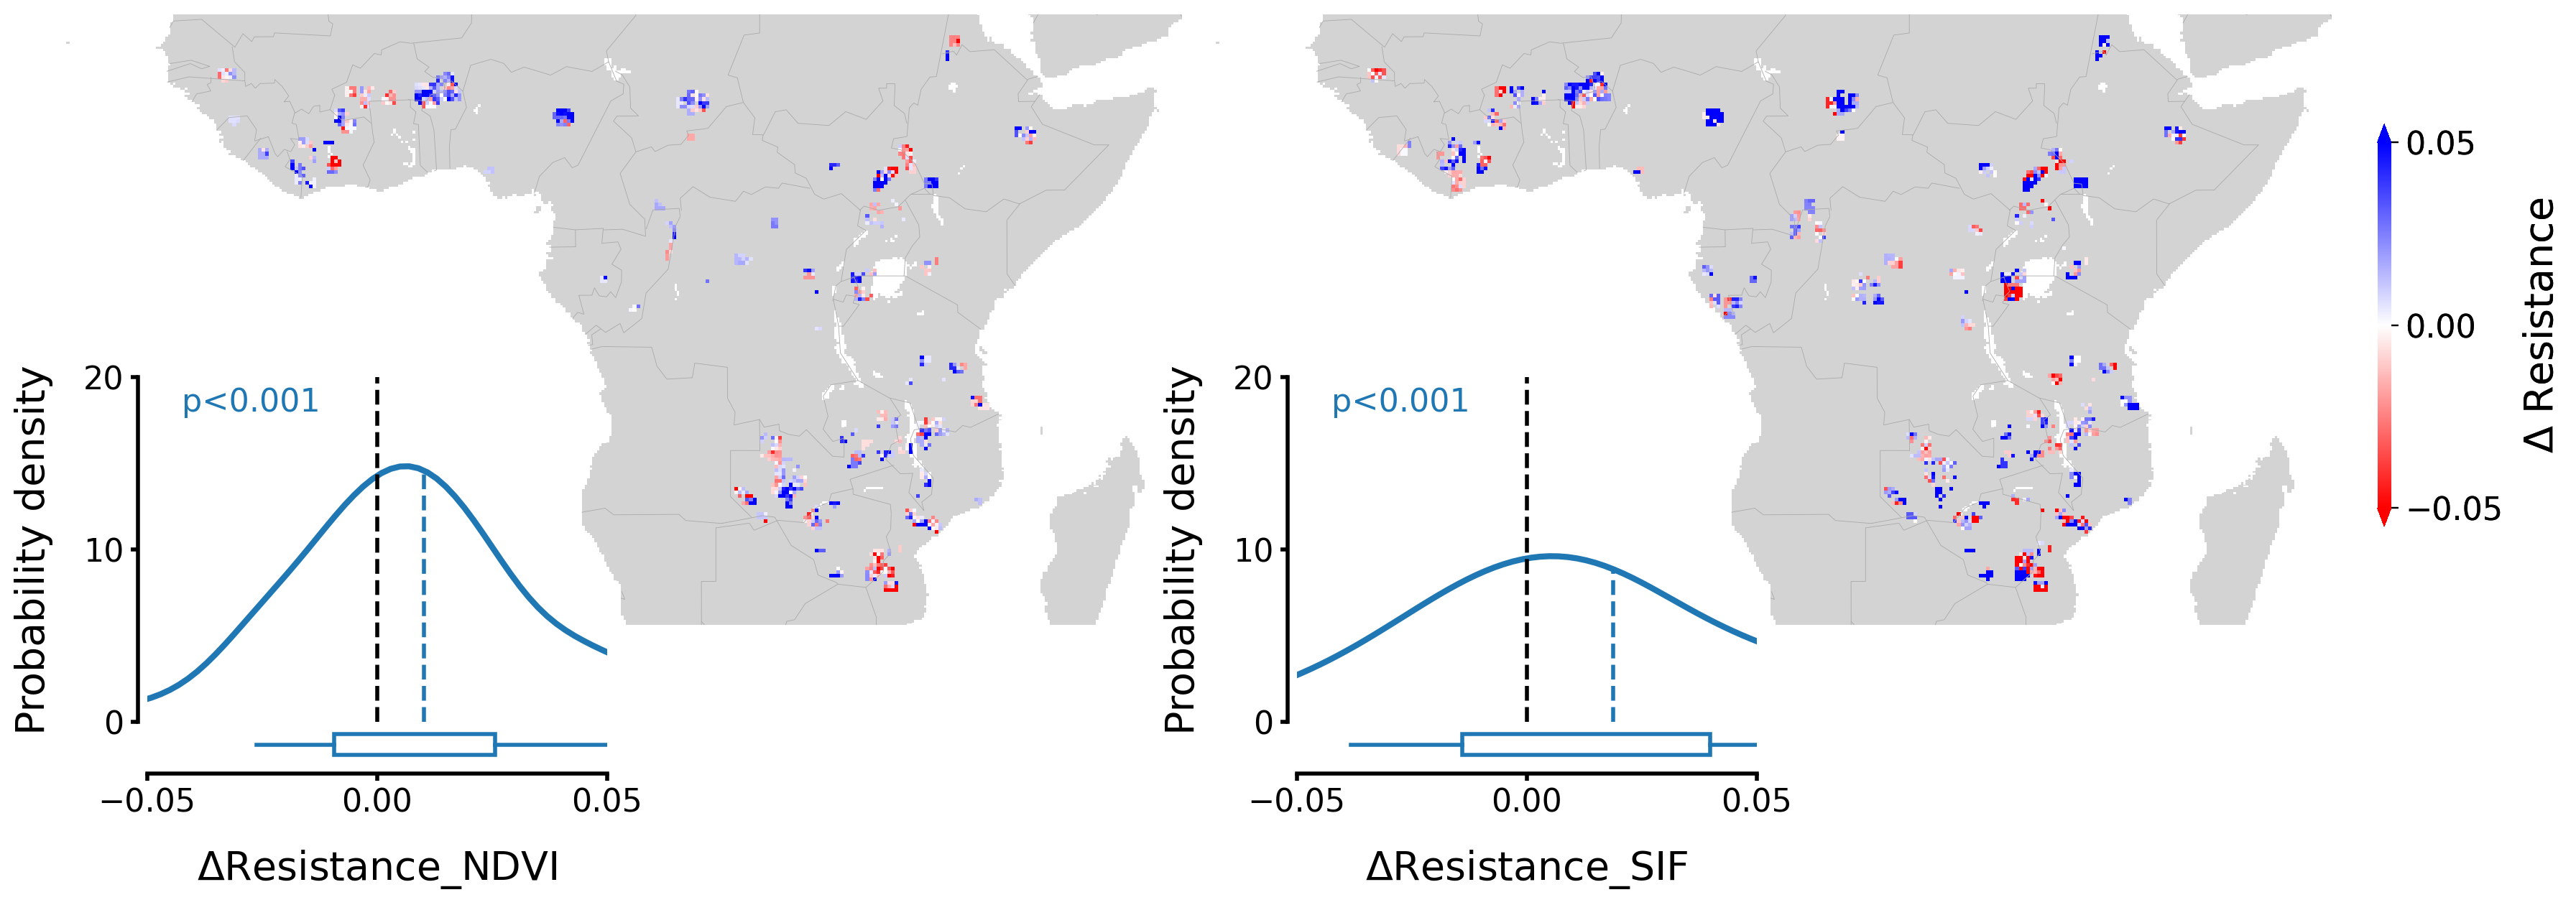

In [13]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]


#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow((delta_m[i])[32:200],cmap ='bwr_r',origin='upper',norm=norm)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(res_delta[i])
    delta_rav=gc.nanravel(res_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    if pp_value1[i]<0.001:
        ax1.text(0.13,0.35, "p<0.001", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value1[i]<0.01:
        ax1.text(0.13,0.35, "p<0.01", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value1[i]<0.05:
        ax1.text(0.13,0.35, "p<0.05", fontsize=16,transform = ax.transAxes,color='C0')
    else:
        ax1.text(0.13,0.35, "p={:.2f}".format(pp_value1[i]), fontsize=16,transform = ax.transAxes,color='C0')
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-3))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,10))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.set(facecolor='none')
    if i ==0:
        ax2=fig.add_axes([0.05,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    else:
        ax2=fig.add_axes([0.55,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(res_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": 'C0',"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':'C0'},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':'C0','color':'C0'})
    ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

### fig protected area

#### grids with production reduction

0.010241939774099386 [14.57327668]
0.018774164605620137 [8.85910586]


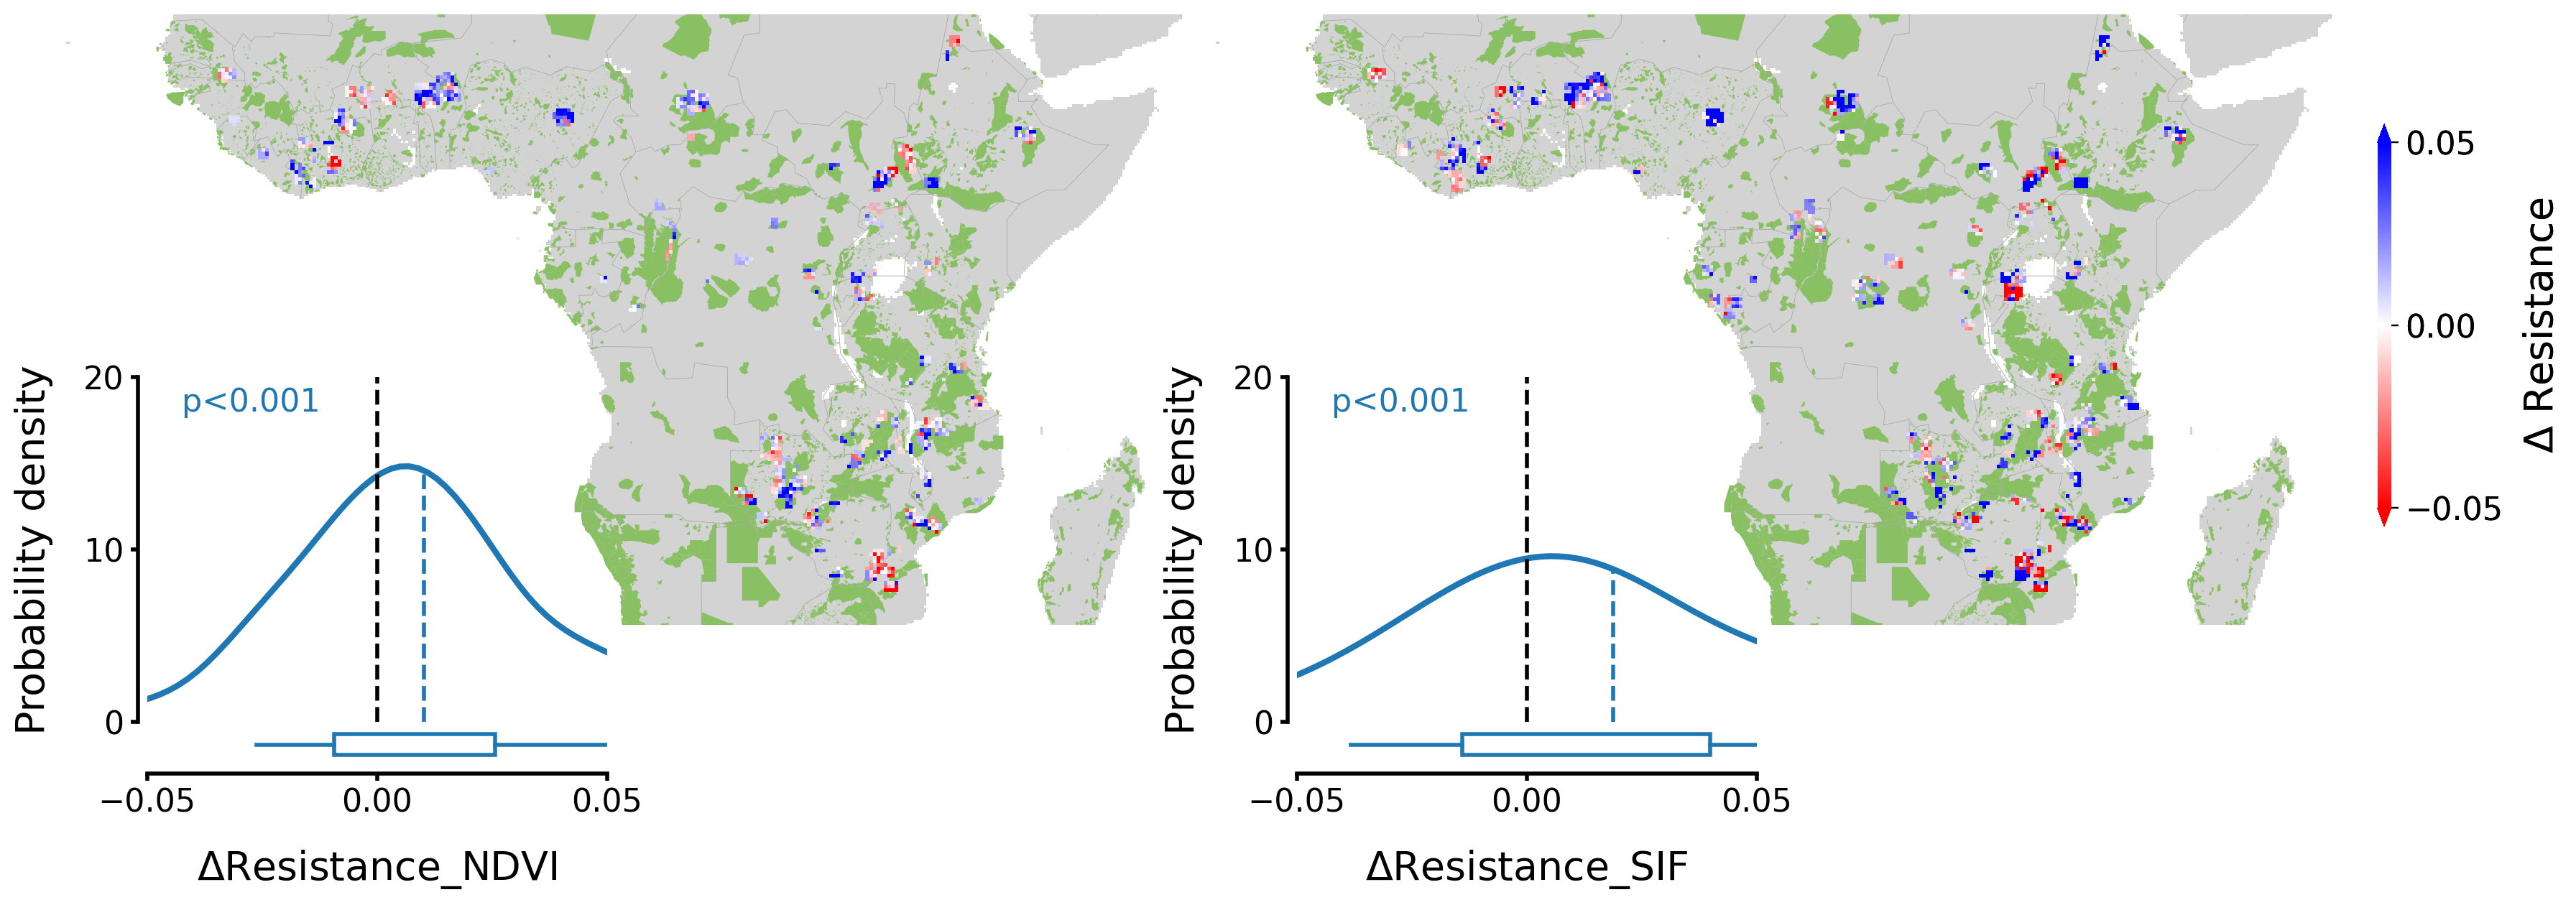

In [55]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]

#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
cl3=np.array([(169,209,142)])/255
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True,zorder=1)
    m.drawcountries(linewidth=0.30, color='darkgrey',zorder=2)
    #叠加保护区范围
    m.readshapefile('//weili/User2/mxsun/CESS_230818/Pattern_drive/WDPA_WDOECM_Nov2023_Public_AF/Protected_area_AF_240911','FID',drawbounds=False,
                zorder=3)
    for info, shp in zip(m.FID_info,m.FID):
        poly=Polygon(shp,facecolor=cl3,edgecolor='None',lw=0.3)
        ax.add_patch(poly)
    #叠加Δ数值
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow((delta_m[i])[32:200],cmap ='bwr_r',origin='upper',norm=norm,zorder=4)#zorder越大越在上面
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(res_delta[i])
    delta_rav=gc.nanravel(res_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    if pp_value1[i]<0.001:
        ax1.text(0.13,0.35, "p<0.001", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value1[i]<0.01:
        ax1.text(0.13,0.35, "p<0.01", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value1[i]<0.05:
        ax1.text(0.13,0.35, "p<0.05", fontsize=16,transform = ax.transAxes,color='C0')
    else:
        ax1.text(0.13,0.35, "p={:.2f}".format(pp_value1[i]), fontsize=16,transform = ax.transAxes,color='C0')
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-3))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,10))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.set(facecolor='none')
    if i ==0:
        ax2=fig.add_axes([0.05,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    else:
        ax2=fig.add_axes([0.55,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(res_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": 'C0',"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':'C0'},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':'C0','color':'C0'})
    ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

#### all grids

0.003978957436901475 [15.75254605]
0.011273393080277397 [9.22908845]


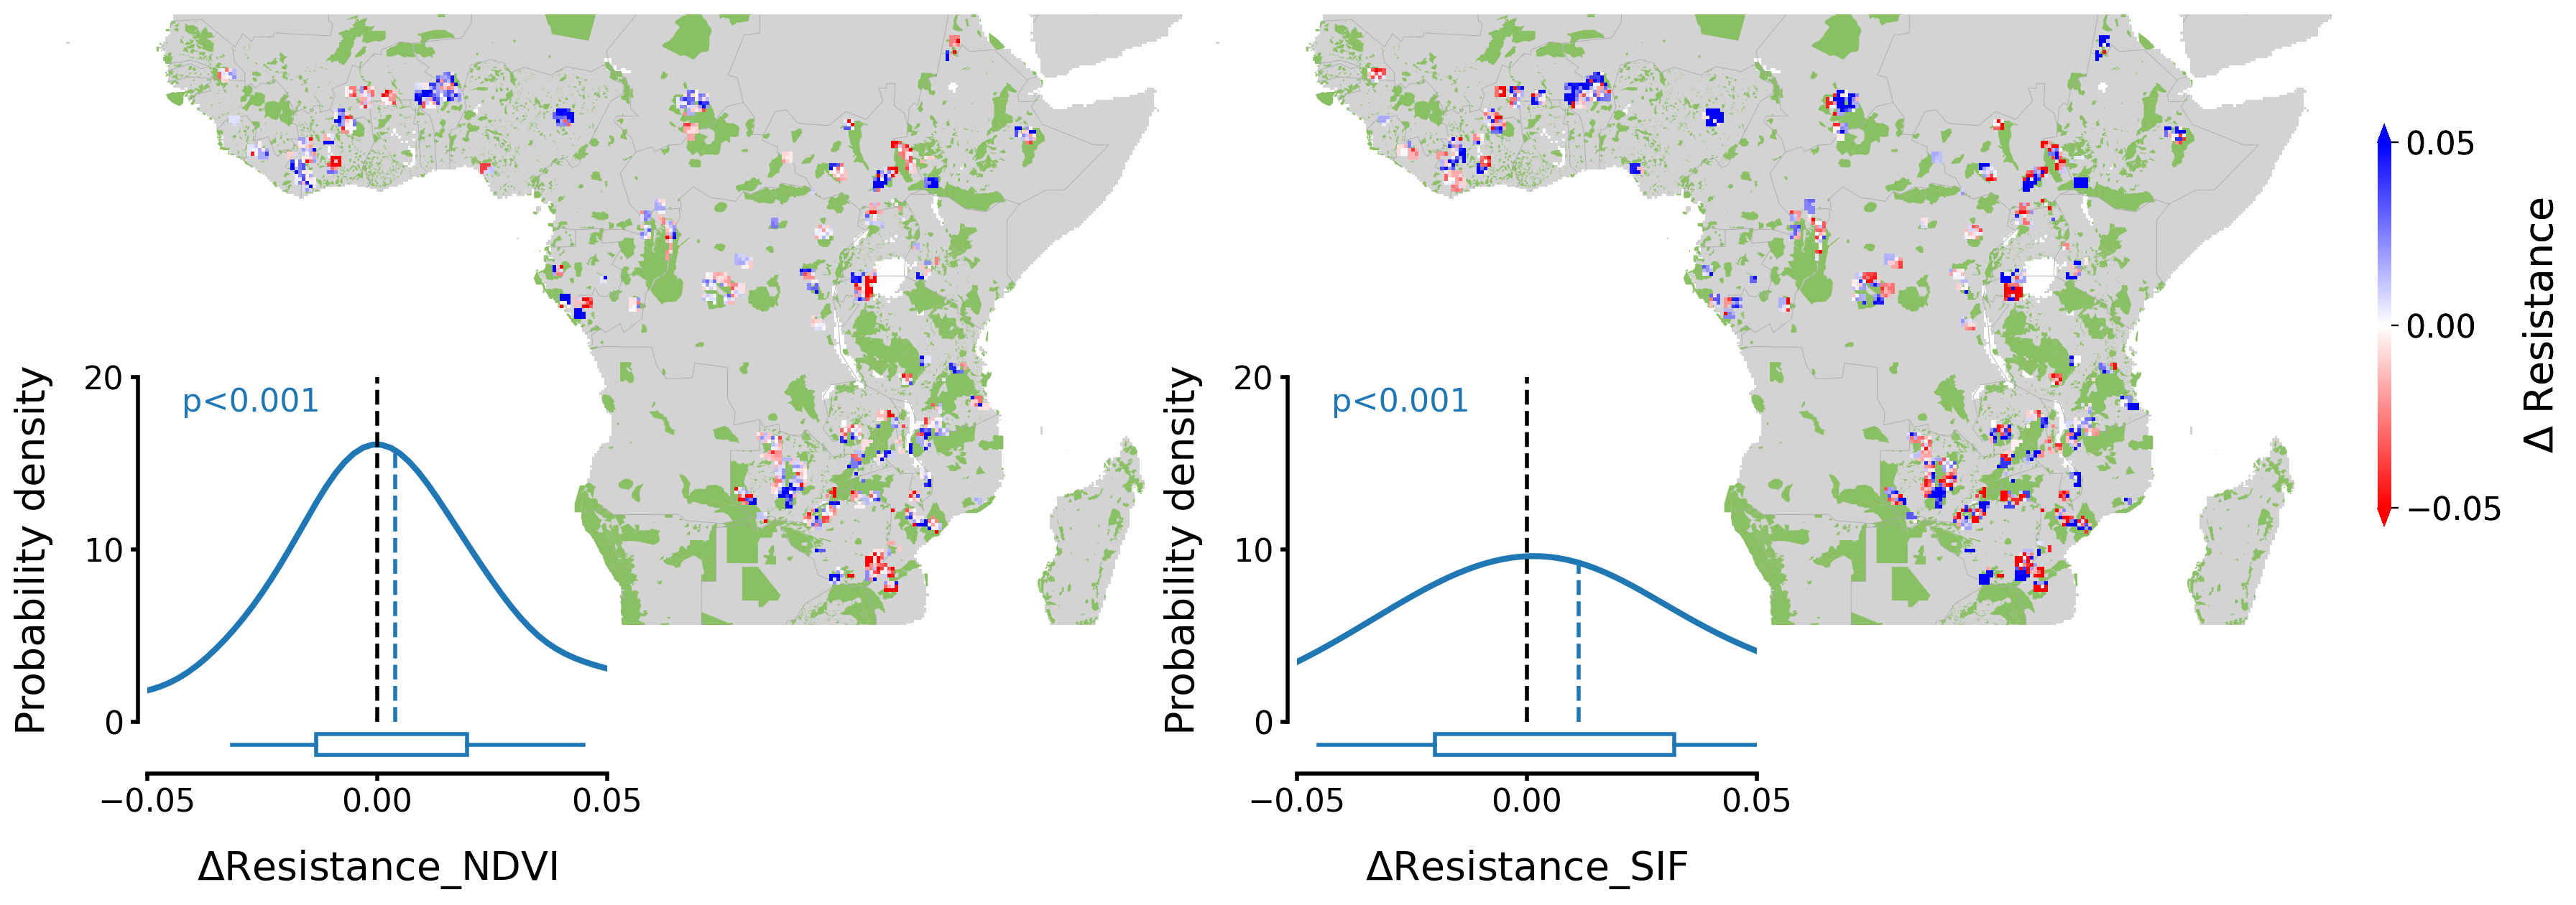

In [56]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]

#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
cl3=np.array([(169,209,142)])/255
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True,zorder=1)
    m.drawcountries(linewidth=0.30, color='darkgrey',zorder=2)
    #叠加保护区范围
    m.readshapefile('//weili/User2/mxsun/CESS_230818/Pattern_drive/WDPA_WDOECM_Nov2023_Public_AF/Protected_area_AF_240911','FID',drawbounds=False,
                zorder=3)
    for info, shp in zip(m.FID_info,m.FID):
        poly=Polygon(shp,facecolor=cl3,edgecolor='None',lw=0.3)
        ax.add_patch(poly)
    #叠加Δ数值
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow((delta[i])[32:200],cmap ='bwr_r',origin='upper',norm=norm,zorder=4)#zorder越大越在上面
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(res_m[i])
    delta_rav=gc.nanravel(res_m[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    if pp_value1[i]<0.001:
        ax1.text(0.13,0.35, "p<0.001", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value1[i]<0.01:
        ax1.text(0.13,0.35, "p<0.01", fontsize=16,transform = ax.transAxes,color='C0')
    elif pp_value1[i]<0.05:
        ax1.text(0.13,0.35, "p<0.05", fontsize=16,transform = ax.transAxes,color='C0')
    else:
        ax1.text(0.13,0.35, "p={:.2f}".format(pp_value1[i]), fontsize=16,transform = ax.transAxes,color='C0')
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-3))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,10))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.set(facecolor='none')
    if i ==0:
        ax2=fig.add_axes([0.05,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    else:
        ax2=fig.add_axes([0.55,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(res_m[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": 'C0',"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':'C0'},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':'C0','color':'C0'})
    ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')